# Histopathologic Cancer Detection

Identify metastatic tissue in histopathologic scans of lymph node sections with [Data from Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/overview).

Construct a CNN to classify images as containing metastatic cancer cells (positive label) or not (negative label).

There are two sets of data: A training set with images and labels and a test set that are images without labels.

In [ ]:
# !pip install numpy pandas matplotlib Pillow scikit-learn tensorflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight

In [47]:
# !kaggle competitions download -c histopathologic-cancer-detection
# !unzip histopathologic-cancer-detection.zip -d data

## Exploratory Data Analysis

Since there really isn't much to the data (just an id and label), I wanted to see how the split between the two labels broke down. 

I then opened a few images of each of the two labels to get a sense of what they look like.

Lastly, I pre-processed the data and split it into training and evaluation sets.

In [48]:
labels = pd.read_csv('data/train_labels.csv')
print(labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


([<matplotlib.axis.XTick at 0x3f0c677d0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

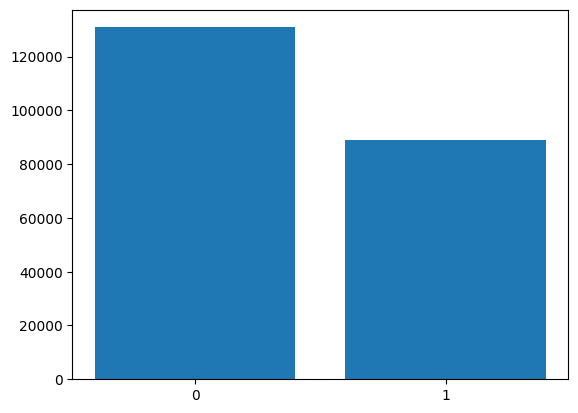

In [49]:
plt.bar(x=labels["label"].value_counts().index, height=labels["label"].value_counts().values)
plt.xticks([0,1])

Label 0 samples:


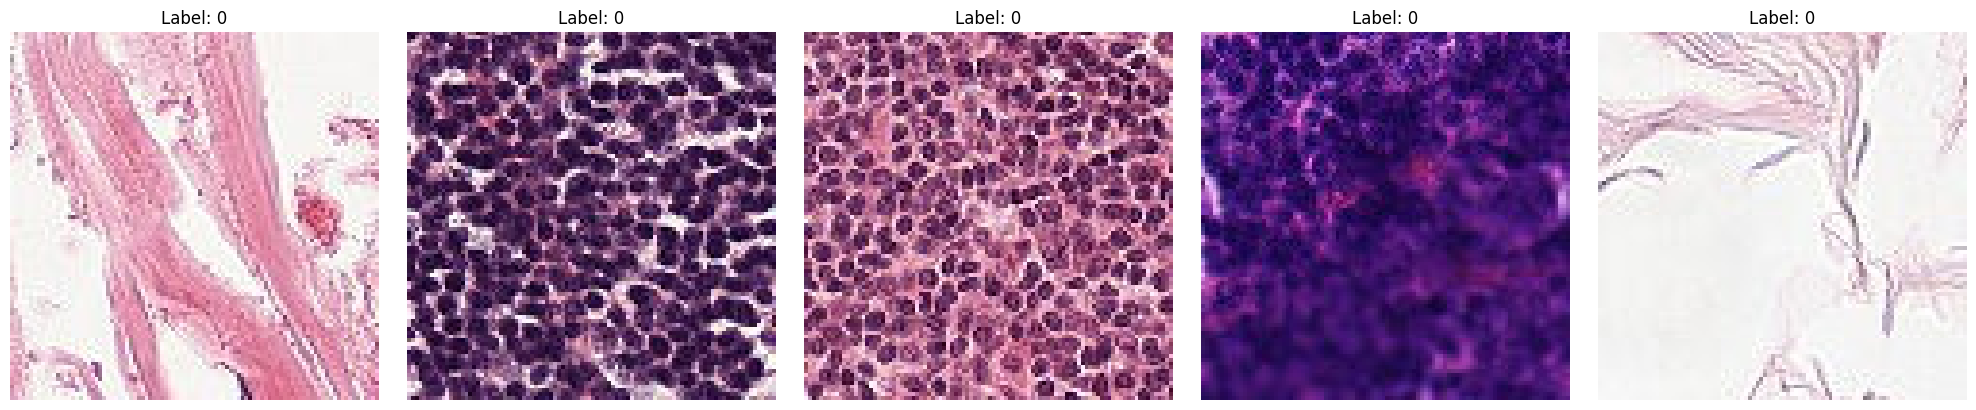

Label 1 samples:


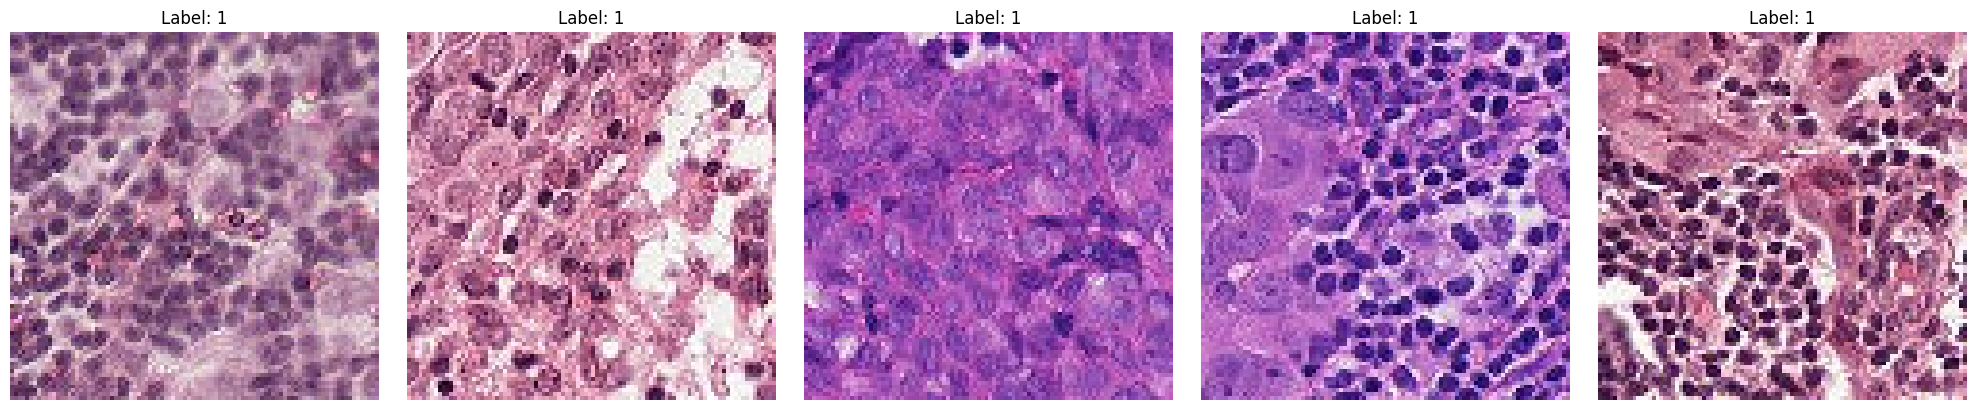

In [50]:
def plot_samples(label=1, n=5):
    fig, ax = plt.subplots(1, n, figsize=(4 * n, 4))

    # Filter by label
    samples = labels[labels['label'] == label].sample(n=n, random_state=42).reset_index(drop=True)

    for i in range(n):
        img_id = samples.iloc[i]['id']
        img = Image.open(f'data/train/{img_id}.tif')
        ax[i].imshow(img)
        ax[i].set_title(f"Label: {label}")
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

print("Label 0 samples:")
plot_samples(label=0, n=5)

print("Label 1 samples:")
plot_samples(label=1, n=5)

In [51]:
def load_images(df, image_dir, n=5000, img_size=(96,96)):
    X, y = [], []
    for i in range(n):
        img_id = df.iloc[i]['id']
        label = df.iloc[i]['label']
        img = Image.open(os.path.join(image_dir, f"{img_id}.tif")).resize(img_size)
        X.append(np.array(img))
        y.append(label)
    return np.array(X), np.array(y)

X, y = load_images(labels, 'data/train', n=10000)
X = X / 255.0
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

## Model Building and Training

For the model building and training, I constructed a pipeline for preparing the image data and building a convolutional neural network (CNN) using TensorFlow/Keras to perform binary image classification. 

The model has 8 layers:

1. Conv2D: 32 filters, 3x3 kernel, ReLU activation — learns low-level features.
2. MaxPooling2D: Reduces spatial dimensions.
3. Another Conv2D layer: 64 filters — learns more complex features.
4. MaxPooling2D again.
5. GlobalAveragePooling2D: Converts 2D feature maps into 1D vector.
6. Dense(128): Fully connected layer with 128 units.
7. Dropout(0.5): Randomly drops 50% of units to prevent overfitting.
8. Dense(1): Single neuron output with sigmoid activation for binary classification.

In [76]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96,96,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
model.summary()

/Users/jonathan/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,841 (108.75 KB)

 Trainable params: 27,841 (108.75 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64, class_weight=class_weights_dict)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - auc: 0.6298 - loss: 0.6659 - val_auc: 0.8280 - val_loss: 0.5476
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - auc: 0.8137 - loss: 0.5312 - val_auc: 0.8388 - val_loss: 0.4981
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - auc: 0.8357 - loss: 0.5018 - val_auc: 0.8440 - val_loss: 0.5022
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - auc: 0.8397 - loss: 0.4973 - val_auc: 0.8447 - val_loss: 0.4911
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - auc: 0.8334 - loss: 0.5070 - val_auc: 0.8394 - val_loss: 0.5152


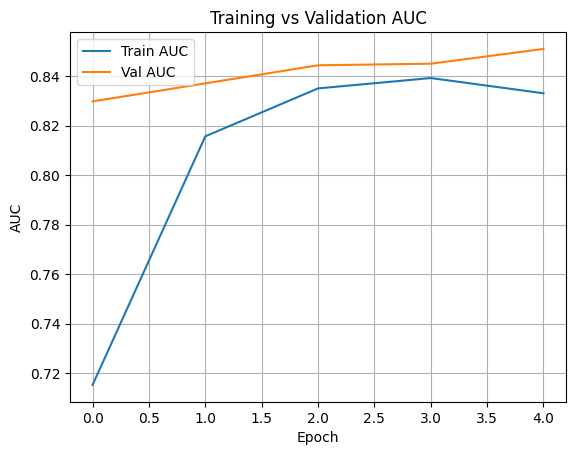

In [ ]:
# print(history.history.keys())

plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training vs Validation AUC')
plt.grid(True)
plt.show()

## Results

In [58]:
test_files = glob.glob("data/test/*.tif")

# This is a modified version of the preprocessing function to handle test images
def preprocess_test_images(file_paths, img_size=(96, 96)):
    X_test = []
    ids = []
    for file_path in file_paths:
        img_id = os.path.basename(file_path).split('.')[0]
        img = Image.open(file_path).resize(img_size)
        X_test.append(np.array(img))
        ids.append(img_id)
    return np.array(X_test) / 255.0, ids

X_test, test_ids = preprocess_test_images(test_files)

In [59]:
preds = model.predict(X_test)
labels = (preds > 0.5).astype(int).reshape(-1)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step


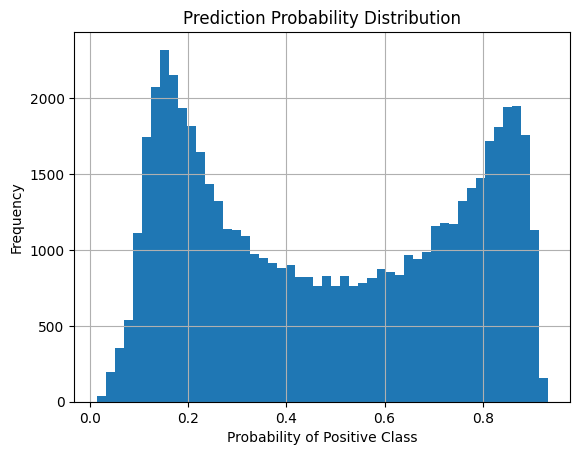

In [60]:
plt.hist(preds, bins=50)
plt.title("Prediction Probability Distribution")
plt.xlabel("Probability of Positive Class")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

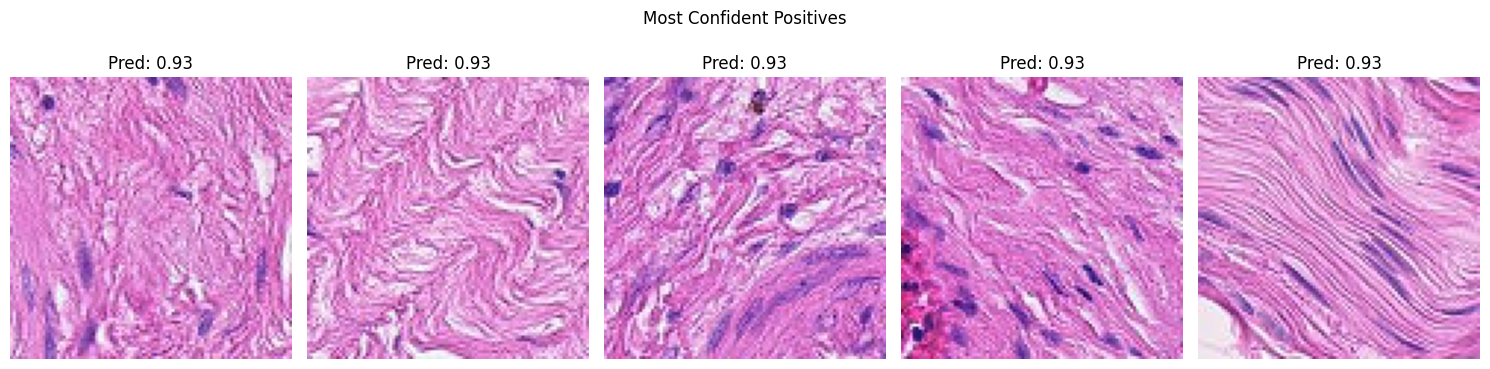

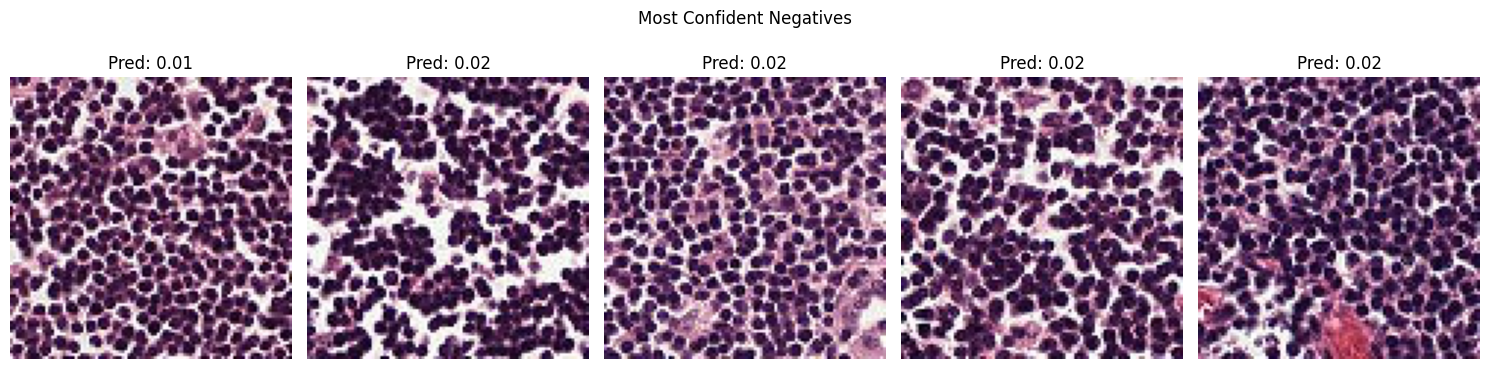

In [61]:
high_conf_pos = np.argsort(-preds.ravel())[:5]
high_conf_neg = np.argsort(preds.ravel())[:5]

def show_predictions(indices, title):
    fig, ax = plt.subplots(1, len(indices), figsize=(15, 4))
    for i, idx in enumerate(indices):
        img = Image.open(test_files[idx])
        ax[i].imshow(img)
        ax[i].set_title(f"Pred: {preds[idx][0]:.2f}")
        ax[i].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_predictions(high_conf_pos, "Most Confident Positives")
show_predictions(high_conf_neg, "Most Confident Negatives")

In [62]:
sample_submission_preview = pd.DataFrame({
    'id': test_ids[:10],
    'probability': preds[:10].ravel(),
    'label': labels[:10]
})

display(sample_submission_preview)

,id,probability,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,0.861435,1
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0.853857,1
2,19709bec800f372d0b1d085da6933dd3ef108846,0.692363,1
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0.448517,0
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0.352703,0
5,761dde7de22cb39a0dd67ce472163d66e5ac1568,0.782310,1
6,58055ce8819717a100b48d019e139be4fdf997c0,0.722460,1
7,9735b584631f4b942b022d40aecdbe2aa8f6ae5e,0.160800,0
8,860bbd33f8483a45858c4998021bc7434117deda,0.711600,1
9,99050fbce64ae16e48e8a3b09d38f3b16df63fbe,0.814942,1


In [63]:
# submission = pd.DataFrame({
#     'id': test_ids,
#     'label': labels
# })
#
# submission.to_csv("submission.csv", index=False)
#
# !kaggle competitions submit -c histopathologic-cancer-detection -f submission.csv -m "Submission"

## Conclusion

In my initial development of this I, I used "accuracy" as my model metric. Training accuracy increased over all 5 epochs. Eventually the training accuracy hit ~81.8%, but I only got a 0.3995 score on Kaggle.

I switched to using area under the curve (AUC) metric based on the suggestion of [this blog post](https://www.baeldung.com/cs/ml-accuracy-vs-auc) since the labels were imbalanced. The AUC hit ~83.3%.

I then looked into ways to balance the data. I used `compute_class_weight` from [scikit-learn](https://scikit-learn.org). Afterwards, I noticed a big improvement in the prediction probability distribution and my score on kaggle went up to .7905.
